In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
pd.set_option("display.max_rows", 100)
from dataclasses import dataclass, asdict, field
# import xml.etree.ElementTree as ET
import cv2
import random
import sys
from pathlib import Path
sys.path.append("..")
from semif_utils.datasets import ImageMetadata, Box, CameraInfo
import rasterio
from rasterio.plot import show as rastershow
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
import json

In [2]:
trial = "NC_2022-03-29"

In [3]:
base_path = f"../data/semifield-developed-images-trial/{trial}"
image_path = f"{base_path}/images"
orthomosaic_path = f"{base_path}/autosfm/ortho/orthomosaic.tif"
annotation_file_path = f"{base_path}/autosfm/detections.csv"
metadata_path = f"{base_path}/metadata"

In [4]:
orthomosaic = rasterio.open(orthomosaic_path)

In [5]:
box_metadata = dict()
metadata_files = os.listdir(metadata_path)
for file in metadata_files:
    image_id = Path(file).stem
    # image_id = file.split(".")[0]
    filename = Path(metadata_path, file)
    with open(filename, "r") as f:
        contents = json.load(f)
    box_metadata[image_id] = contents

In [6]:
def disp_orthomosaic():
    f, ax = plt.subplots(1, 1, dpi=200)
    rastershow(orthomosaic, ax=ax)
    plt.show()

In [7]:
# Utility plotting function to plot all the identified primary boxes
def plot_rectangle(image_metadata, display_orthomosaic=True, seed=42):
    
    import random
    random.seed(seed)
    
    # image_store = {image.image_id: image for image in images}
    
    f, ax = plt.subplots(1, 1, dpi=300)
    ax.set_aspect("equal", adjustable="box")
    
    if display_orthomosaic:
        rastershow(orthomosaic, ax=ax)
    
    bboxes_plotted = set()
    
    primary_bboxes = []
    
    for img in image_metadata.keys():        
        r, g, b = random.random(), random.random()%0.5, random.random()
        img_color = (r, g, b, 0.05)
        linewidth = 1
        handle = ax.scatter(
            image_metadata[img]["camera_info"]["camera_location"][0], 
            image_metadata[img]["camera_info"]["camera_location"][1], 
            marker="x", color=img_color)
        
        for bbox in image_metadata[img]["bboxes"]:
            if bbox['bbox_id'] in bboxes_plotted:
                continue
            
            if bbox["is_primary"]:
                # pprint(bbox)
                primary_bboxes.append(bbox)
            else:
                r, g, b = random.random(), random.random(), random.random()
                color = (r, g, b, 0.05)
                linewidth = 1
                
                anchor = bbox["global_coordinates"]["bottom_left"]
                width = bbox["global_coordinates"]["top_right"][0] - bbox["global_coordinates"]["top_left"][0]
                height = bbox["global_coordinates"]["top_left"][1] - bbox["global_coordinates"]["bottom_left"][1]
                patch = Rectangle(anchor, width, height, facecolor="none", edgecolor=color, linewidth=linewidth, linestyle="--")
                ax.add_patch(patch)

                bboxes_plotted.add(bbox["bbox_id"])
    
    classes = list(set([bbox["bbox_id"] for bbox in primary_bboxes]))
    cls_colors = dict()
    for cls in classes:
        r, g, b = random.random(), random.random()%0.5, random.random()
        color = (r, g, b)
        cls_colors[cls] = color
    
    labels = []
    handles = []
    # Plot the primary bboxes
    for bbox in primary_bboxes:
        color = cls_colors[bbox["bbox_id"]]
        linewidth = 1
        
        anchor = bbox["global_coordinates"]["bottom_left"]
        width = bbox["global_coordinates"]["top_right"][0] - bbox["global_coordinates"]["top_left"][0]
        height = bbox["global_coordinates"]["top_left"][1] - bbox["global_coordinates"]["bottom_left"][1]
        patch = Rectangle(anchor, width, height, facecolor="none", edgecolor=color, linewidth=linewidth)
        ax.add_patch(patch)
        
        # Highlight the image fov and center
        img = iimage.width
    ax.legend(handles, labels, ncol=5, loc="lower left", fontsize="xx-small", bbox_to_anchor=(0.8, 1.0))
    plt.show()

In [8]:
@dataclass
class Image:
    """Parent class for RemapImage and ImageData.
    """
    image_id: str
    image_path: str
    data_root: str
    batch_id: str

    def __post_init__(self):
        image_array = self.array
        self.width = image_array.shape[1]
        self.height = image_array.shape[0]

    @property
    def array(self):
        # Read the image from the file and return the numpy array
        img_path = Path("../data", self.data_root, self.batch_id, self.image_path)
        img_array = cv2.imread(str(img_path))
        img_array = np.ascontiguousarray(
            cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        return img_array

@dataclass
class ImageData(Image):
    """ Dataclass for segmentation and synthetic data generation"""
    data_root: str
    image_path: str
    batch_id: str
    width: int
    height: int
    exif_meta: ImageMetadata
    # cutouts: list[Cutout] = None
    cutout_ids: list[str] = None
    camera_info: CameraInfo = None
    bboxes: list[Box] = None


def plot_local(images):
    
    for img in images:
        f, ax = plt.subplots(1, 1, dpi=100)
        ax.imshow(img.array)
        
        for bbox in img.bboxes:
            anchor = bbox["local_coordinates"]["bottom_left"]
            width =  bbox["local_coordinates"]["top_right"][0] - bbox["local_coordinates"]["top_left"][0]
            height = bbox["local_coordinates"]["top_left"][1] -  bbox["local_coordinates"]["bottom_left"][1]
            patch = Rectangle(anchor, width, height, facecolor="none", edgecolor=(1., 0., 0.), linewidth=1)
            ax.add_patch(patch)
        ax.set_title(img.image_id)
        plt.show()
        plt.close()

def get_imagedata(json_list):
    images = []
    for meta in json_list:
        # Opening JSON file
        meta = Path(metadata_path, meta)
        with open(meta) as json_file:
            data = json.load(json_file)
            dc = ImageData(**data)
            images.append(dc)
    return images


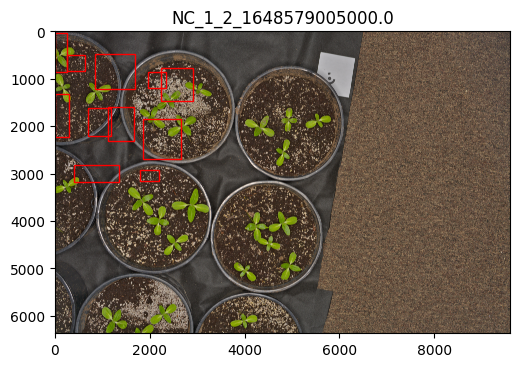

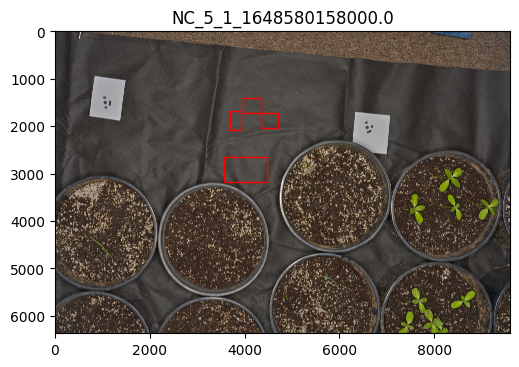

In [9]:
metas = [x.name for x in Path(metadata_path).glob("*.json")]
# random sample of jsons
metas = random.sample(metas, 2)
images = get_imagedata(metas)
plot_local(images)



In [10]:
# disp_orthomosaic()

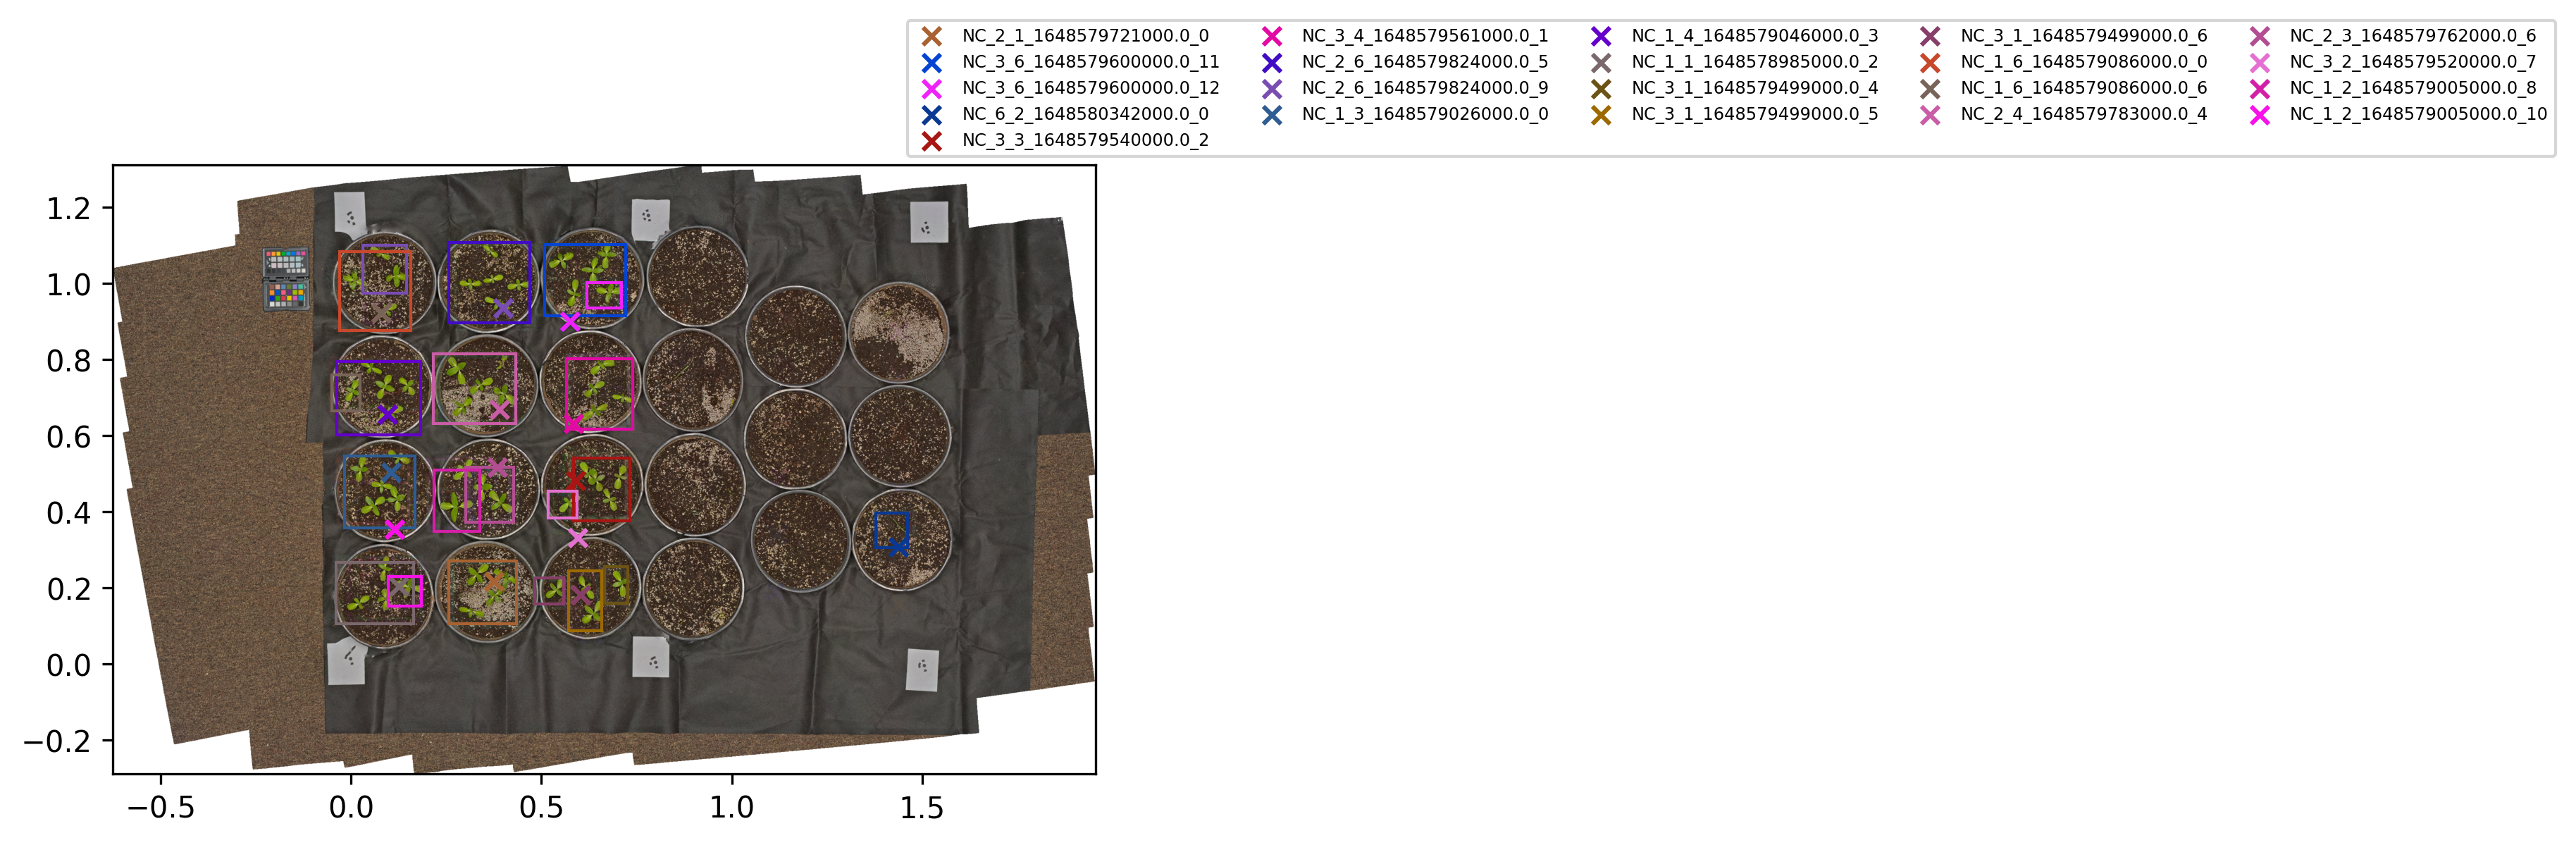

In [11]:
plot_rectangle(box_metadata, display_orthomosaic=True, seed=424242)

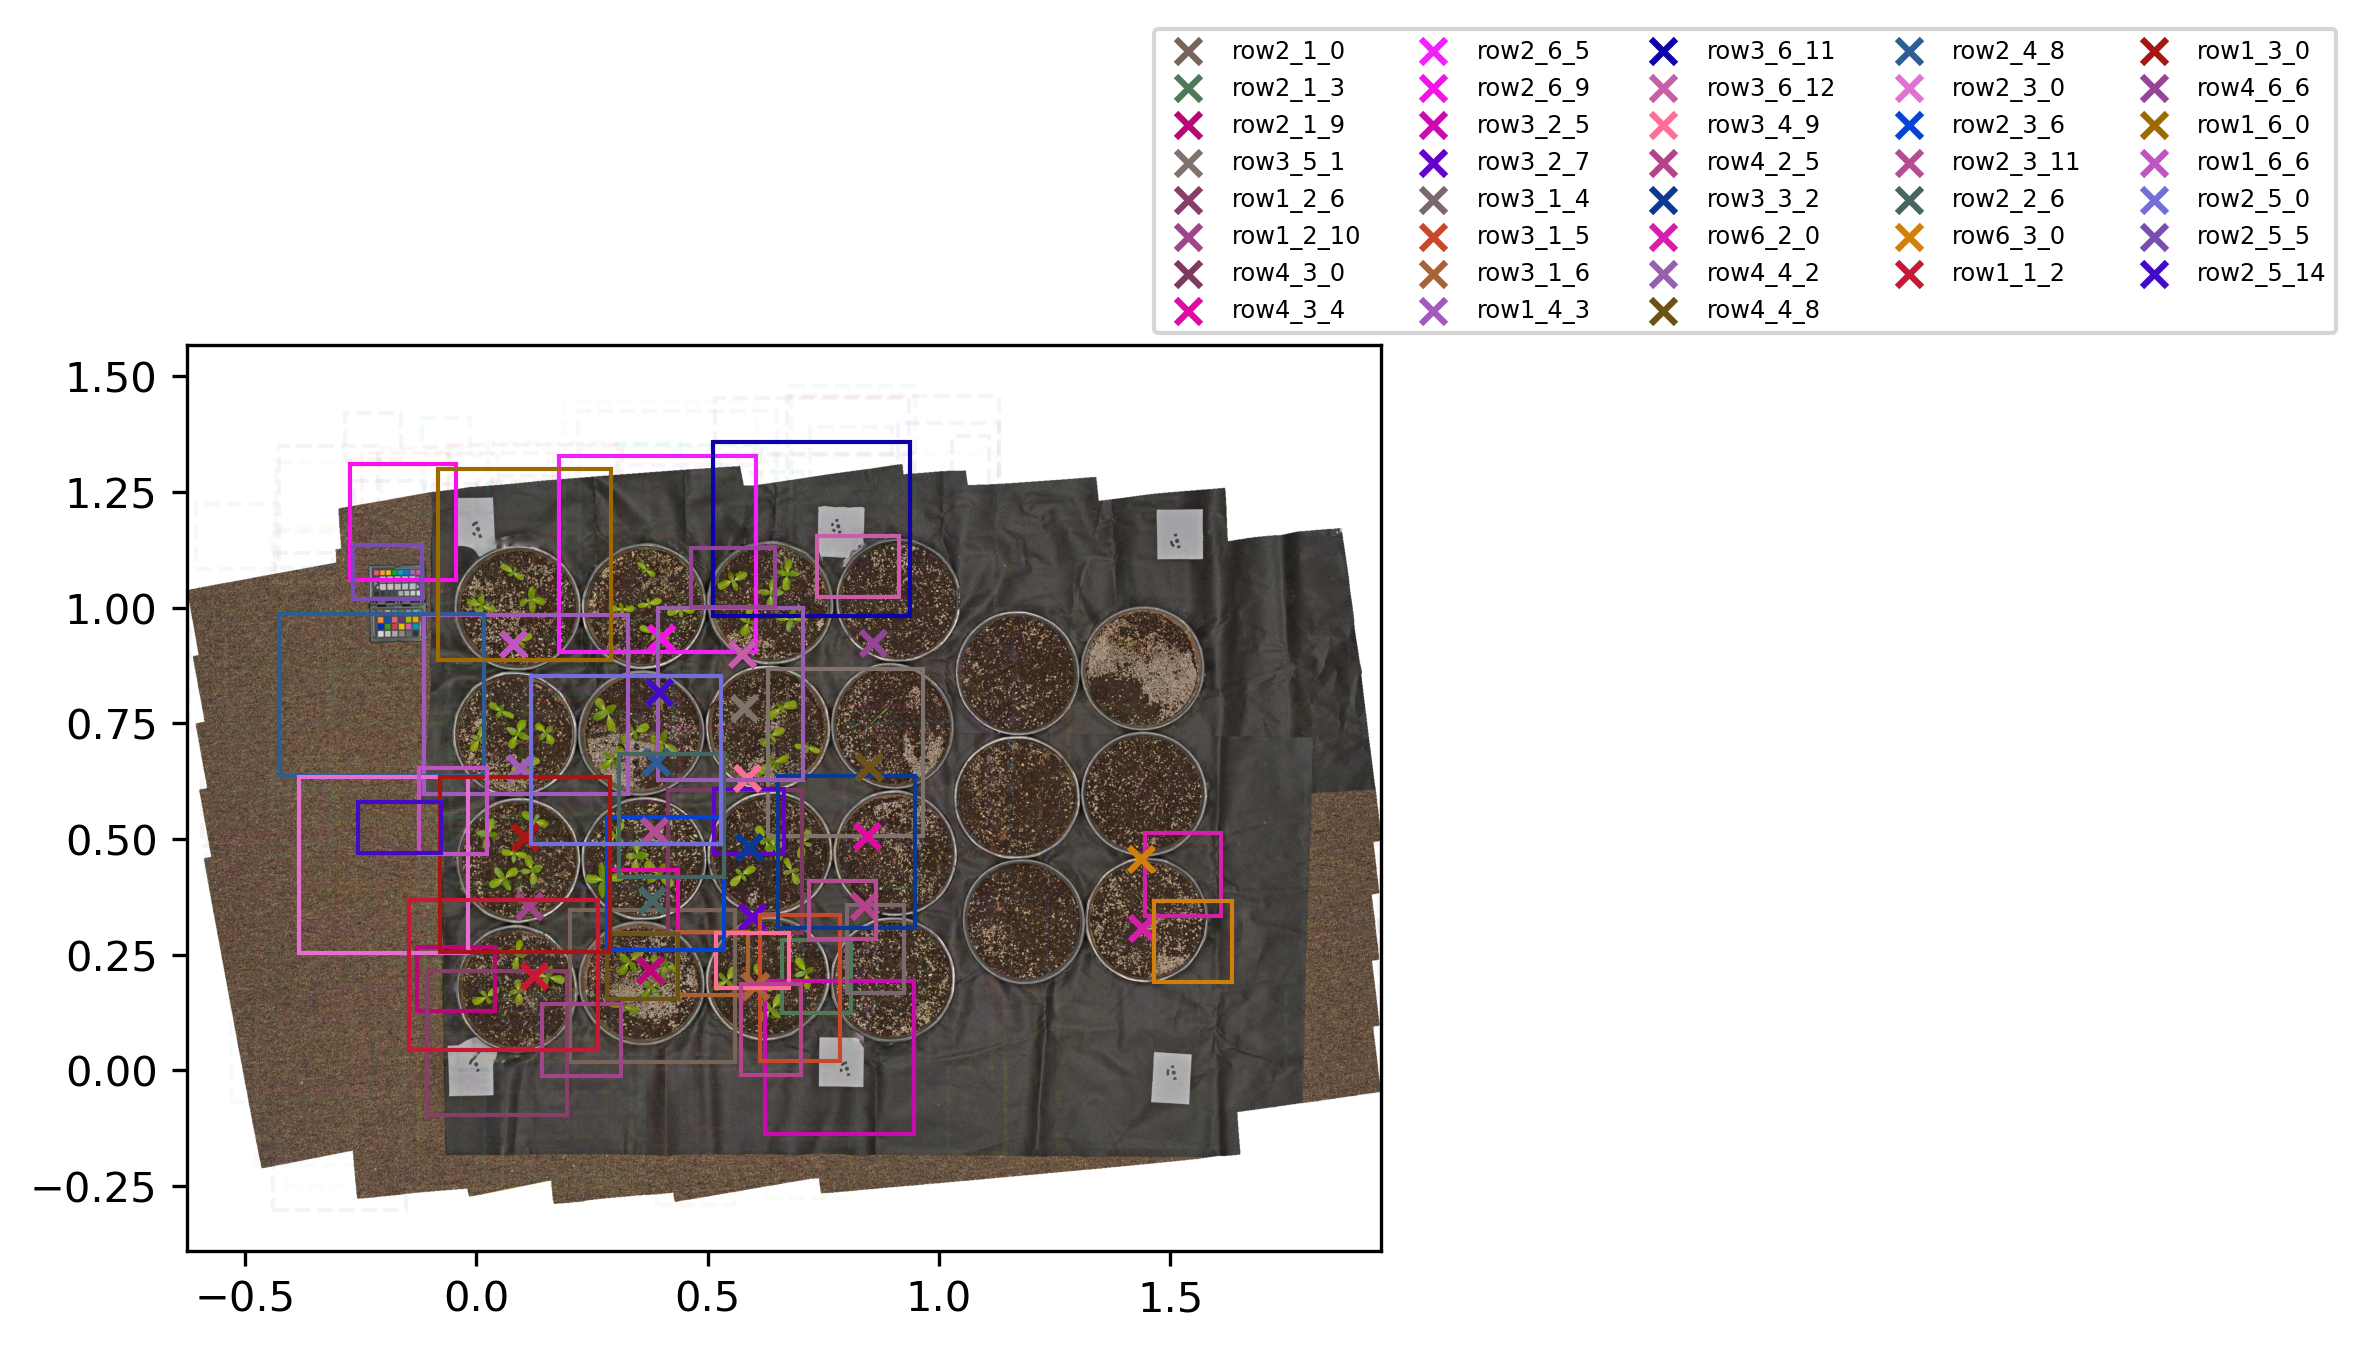

In [10]:
plot_rectangle(box_metadata, display_orthomosaic=True, seed=424242)